In [1]:
#DATASET taken from "https://www.kaggle.com/datasets/nikhil7280/weather-type-classification?resource=download"

In [4]:
#load all the relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,SGDClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,accuracy_score, confusion_matrix, classification_report
from sklearn import ensemble
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna #For helping me in hyperparameter tuning
from time import time


In [5]:


print(sklearn.__version__)

1.5.1


# DATA Handling & DATA Cleaning

In [6]:
#Loading of the dataset
df_starter=pd.read_csv('weather_classification_data.csv')
df_starter.head()
#This displays the first 5 rows of the dataset

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [7]:
df_starter.tail()
#Then this displays the last 5 rows of the dataset

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy
13199,-5.0,38,0.0,92.0,overcast,1015.37,5,Autumn,10.0,mountain,Rainy


In [8]:
#Shows the amount of features and rows in the dataset
df_starter.shape

(13200, 11)

In [9]:
list(df_starter.columns)
#Target Feature will be 'Weather Type' which will mean my target to predict is the the type of weather


['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Cloud Cover',
 'Atmospheric Pressure',
 'UV Index',
 'Season',
 'Visibility (km)',
 'Location',
 'Weather Type']

# Before DATA preparation

In [10]:
from os import remove


np.random.seed(90)#Random seed shall be set to 90 permanently
#This is to remove 2 rows for showcasing to teacher during presentation
removed_rows_of2=np.random.choice(df_starter.index,2,replace=False)
df=df_starter.drop(removed_rows_of2)
removed_rows=df_starter.loc[removed_rows_of2]
print(f"\nRows to take out for testing: \n{removed_rows}")



Rows to take out for testing: 
      Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
9752         30.0        99        11.5               78.0       overcast   
4814         18.0        96        13.0               55.0  partly cloudy   

      Atmospheric Pressure  UV Index  Season  Visibility (km) Location  \
9752               1005.65         3  Spring              3.5   inland   
4814               1004.65         2  Autumn              4.5  coastal   

     Weather Type  
9752        Rainy  
4814        Rainy  


In [11]:
print(df.info())
#This is used to check for data type and for missing values and as can be seen below since all the rows match 13200, there are no missing values

<class 'pandas.core.frame.DataFrame'>
Index: 13198 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13198 non-null  float64
 1   Humidity              13198 non-null  int64  
 2   Wind Speed            13198 non-null  float64
 3   Precipitation (%)     13198 non-null  float64
 4   Cloud Cover           13198 non-null  object 
 5   Atmospheric Pressure  13198 non-null  float64
 6   UV Index              13198 non-null  int64  
 7   Season                13198 non-null  object 
 8   Visibility (km)       13198 non-null  float64
 9   Location              13198 non-null  object 
 10  Weather Type          13198 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.2+ MB
None


In [12]:
df_type = df.groupby('Weather Type', axis=0).size()

df_type.head()
#These 4 Weather types are what we want to predict

C:\Users\Patri\AppData\Local\Temp\ipykernel_58480\3939846903.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_type = df.groupby('Weather Type', axis=0).size()


Weather Type
Cloudy    3300
Rainy     3298
Snowy     3300
Sunny     3300
dtype: int64

# Check DUPLICATES


In [13]:
df[df.duplicated()]#Since this outputs an empty dataframe, there are no duplicates in the dataset

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type


In [14]:
df.nunique()
#The precipitation feature is %based, when we check for unique values, we see there are 110 unique values for it, when in actuality it should be 100, this means there are anomalies for precipitation


Temperature              126
Humidity                  90
Wind Speed                97
Precipitation (%)        110
Cloud Cover                4
Atmospheric Pressure    5456
UV Index                  15
Season                     4
Visibility (km)           41
Location                   3
Weather Type               4
dtype: int64

# Handling Precipitation and Humidity

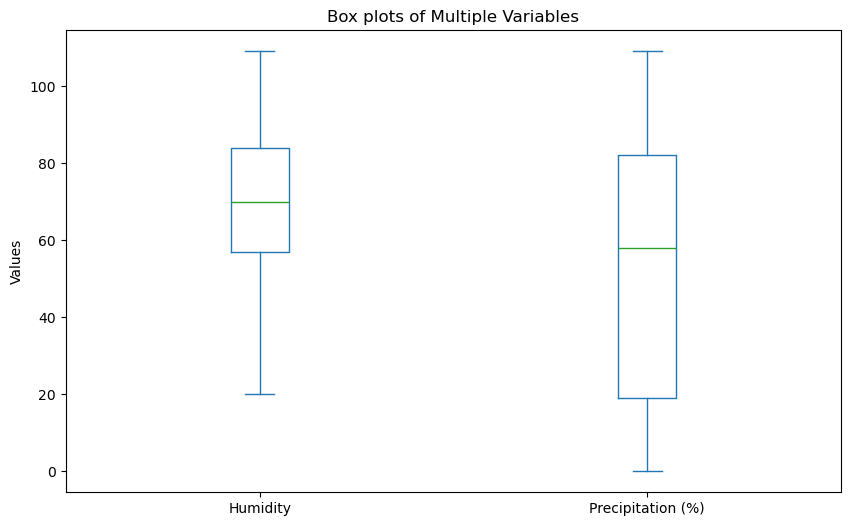

In [15]:
percentage_based_columns = [ "Humidity", "Precipitation (%)"] #I use this to check for anomalies in the percentage based columns

df[percentage_based_columns].plot(kind="box", figsize=(10, 6))

plt.title('Box plots of Multiple Variables')
plt.ylabel('Values')
plt.show() #Based off the results we can see that for both columns they have values exceeding 100% which is not possible considering their nature.

In [16]:
mask = df[percentage_based_columns] > 100#Makes a boolean mask for the values that exceed 100%

print(mask)# Display the boolean mask(This helps me make a True or a False checker for the values that exceed 100%)


rows_exceeding_100 = df[mask.any(axis=1)]#This is used to check for the rows that exceed 100%

print(rows_exceeding_100) #As can be seen below, there are 717 rows that exceed 100% 

       Humidity  Precipitation (%)
0         False              False
1         False              False
2         False              False
3         False              False
4         False              False
...         ...                ...
13195     False              False
13196     False              False
13197     False              False
13198     False              False
13199     False              False

[13198 rows x 2 columns]
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
9             28.0        74         8.5              107.0          clear   
19            13.0       102        12.0               72.0          clear   
24            38.0        83         7.0              101.0  partly cloudy   
37             2.0       105        19.0              109.0       overcast   
56            41.0        85         9.0              101.0       overcast   
...            ...       ...         ...                ...            ...   
13090   

In [17]:
total_rows = 13200
rows_to_remove = 717

percentage_removed = (rows_to_remove / total_rows) * 100
print(f"Percentage of rows to be removed: {percentage_removed:.2f}%")

Percentage of rows to be removed: 5.43%


In [18]:
df_removed_percent= df[~mask.any(axis=1)]#This is used to remove the rows that exceed 100%
print(df_removed_percent)#As can be seen below, the rows have been removed

       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0             14.0        73         9.5               82.0  partly cloudy   
1             39.0        96         8.5               71.0  partly cloudy   
2             30.0        64         7.0               16.0          clear   
3             38.0        83         1.5               82.0          clear   
4             27.0        74        17.0               66.0       overcast   
...            ...       ...         ...                ...            ...   
13195         10.0        74        14.5               71.0       overcast   
13196         -1.0        76         3.5               23.0         cloudy   
13197         30.0        77         5.5               28.0       overcast   
13198          3.0        76        10.0               94.0       overcast   
13199         -5.0        38         0.0               92.0       overcast   

       Atmospheric Pressure  UV Index  Season  Visibility (km) 

In [19]:
numerical_cols=df_removed_percent.select_dtypes(include='number').columns
print(f"Numerical Columns: {numerical_cols}")

Numerical Columns: Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')


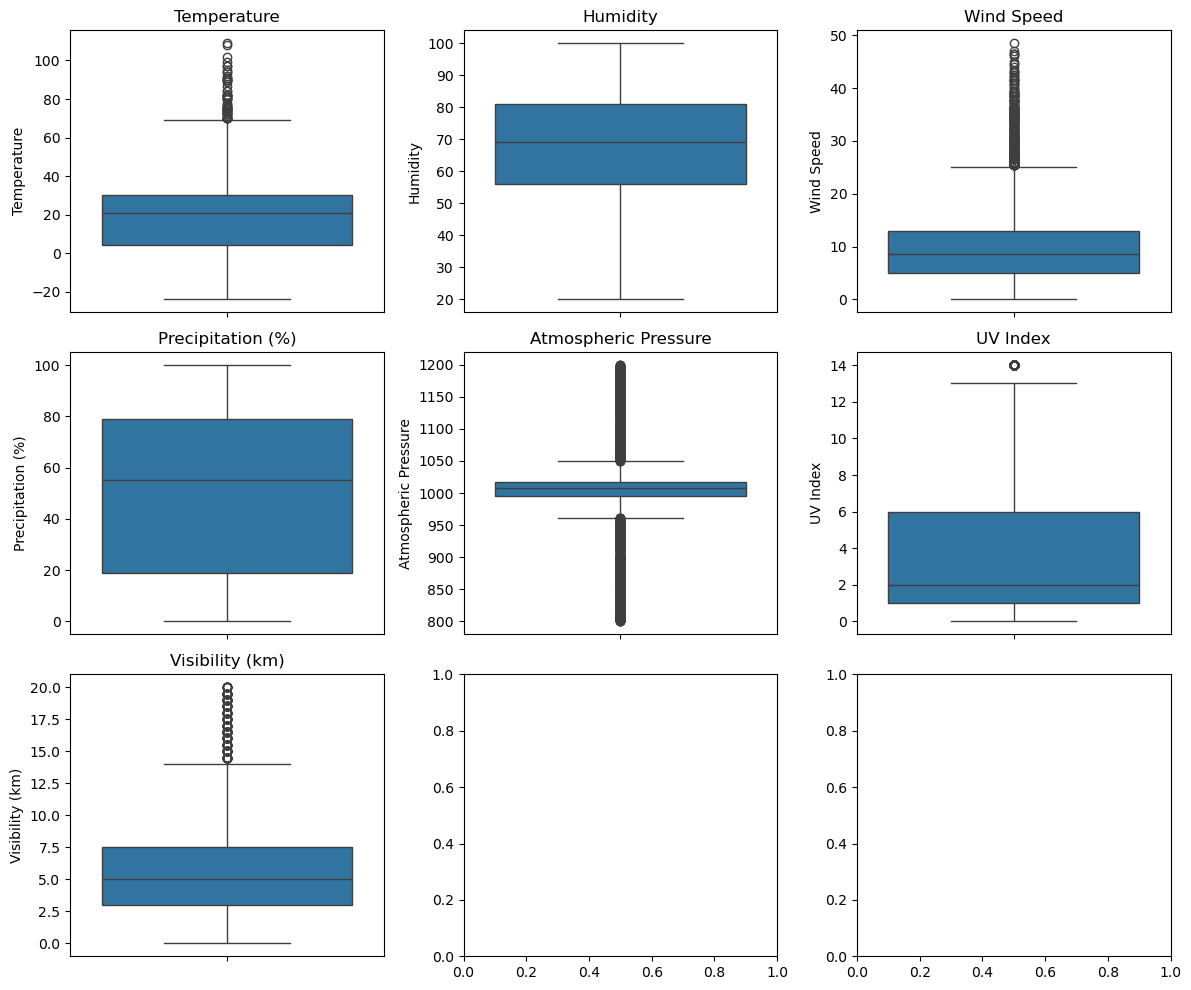

In [20]:
# adapted from Naman Trisoliya's solution. Source: https://www.kaggle.com/code/namantrisoliya/statistical-analysis-8-ml-models-acc-92-34/notebook#Training-Models
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(12,10))
ax = ax.flatten()

for i,col in enumerate(numerical_cols):
    k=sns.boxplot(data=df_removed_percent,y=col,ax=ax[i])
    ax[i].set_title(col)
    
plt.tight_layout()
plt.show()
#Here we have dealt with Humiodity and Precipitation columns, we can see that the values are now within the range of 0-100%, then comes the other numerical columns which each have their own outliers.

# HANDLING Temperature

In [21]:
df_removed_percent.describe()#This is used to get the summary statistics of the dataset

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,12481.000000,12481.000000,12481.000000,12481.000000,12481.000000,12481.000000,12481.000000
mean,18.612211,67.095265,9.394119,51.205112,1005.814804,3.825094,5.532489
std,16.673887,19.381336,6.361318,31.020995,38.137574,3.746571,3.377244
min,-24.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,56.000000,5.000000,19.000000,994.690000,1.000000,3.000000
50%,21.000000,69.000000,8.500000,55.000000,1007.660000,2.000000,5.000000
75%,30.000000,81.000000,13.000000,79.000000,1016.830000,6.000000,7.500000
max,109.000000,100.000000,48.500000,100.000000,1199.210000,14.000000,20.000000


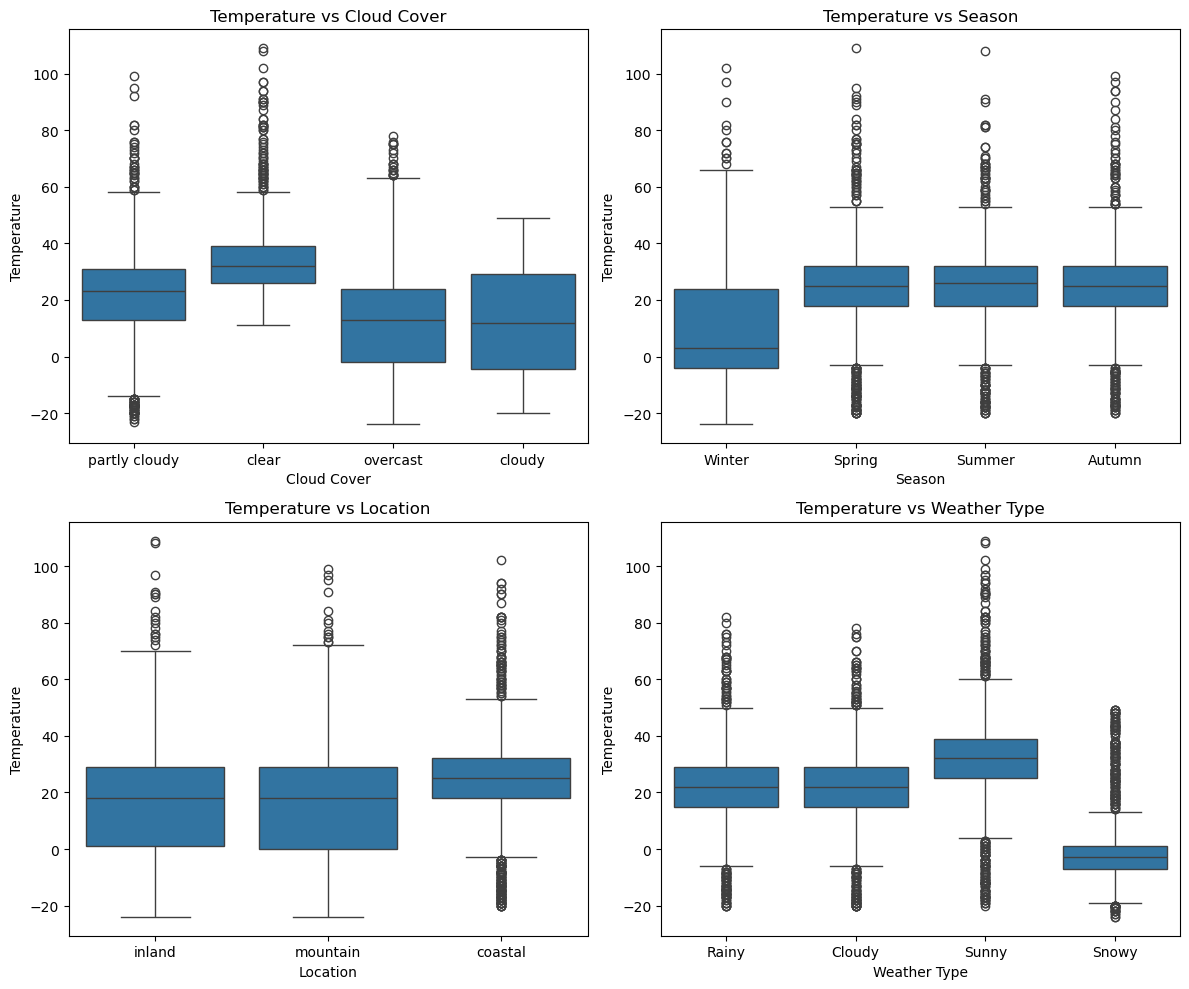

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax = ax.flatten()

categorical_cols = ['Cloud Cover', 'Season', 'Location', 'Weather Type']

for i, col in enumerate(categorical_cols):
    sns.boxplot(data=df_removed_percent, x=col, y='Temperature', ax=ax[i])
    ax[i].set_title(f'Temperature vs {col}')
    ax[i].set_ylabel('Temperature')

plt.tight_layout()
plt.show()
#Looking at the boxplots below, we can see that the temperature in season is above 69 degrees celcius during winter, this means that temperaure has several outliers I have to look into

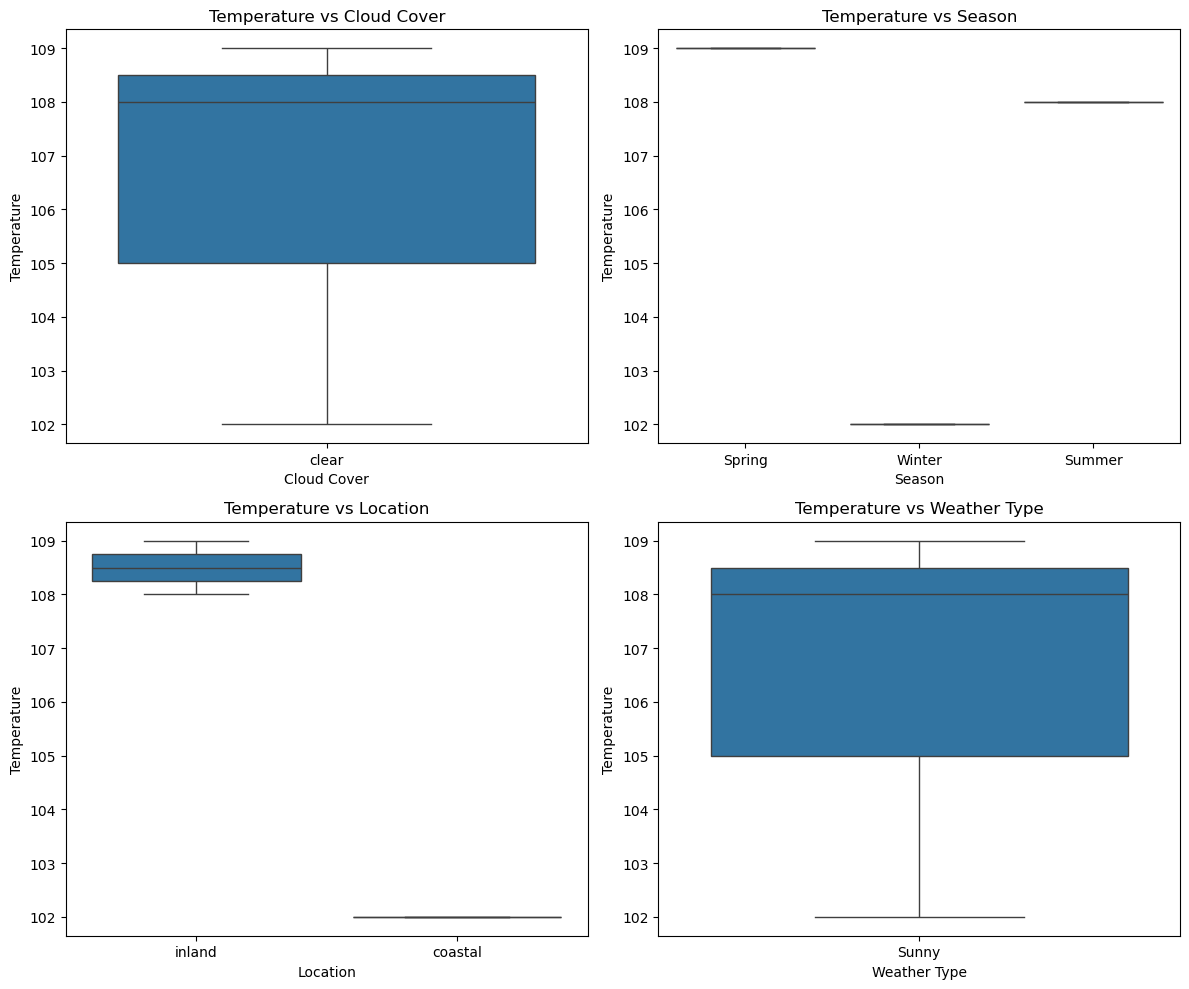

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax = ax.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(data=df_removed_percent[df_removed_percent['Temperature'] > 100], x=col, y='Temperature', ax=ax[i])
    ax[i].set_title(f'Temperature vs {col}')
    ax[i].set_ylabel('Temperature')

plt.tight_layout()
plt.show()

In [24]:
# Method taken from https://www.tableau.com/data-insights/reference-library/visual-analytics/charts/box-whisker

Q1 = np.percentile(df_removed_percent['Temperature'], 25)
Q3 = np.percentile(df_removed_percent['Temperature'], 75)
IQR = Q3 - Q1

upper_whisker = Q3 + 1.5 * IQR

max_temperature_in_box_plot = df_removed_percent['Temperature'][df_removed_percent['Temperature'] <= upper_whisker].max()

print(f' Interquantile Range: {IQR:.2f}\n Upper Whisker: {upper_whisker:.2f}\n Maximum Temperature in Box Plot before considered outlier: {max_temperature_in_box_plot:.2f}')



 Interquantile Range: 26.00
 Upper Whisker: 69.00
 Maximum Temperature in Box Plot before considered outlier: 69.00


In [25]:
Q1 = np.percentile(df_removed_percent['Temperature'], 25)
Q3 = np.percentile(df_removed_percent['Temperature'], 75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR

min_temperature_in_box_plot = df_removed_percent['Temperature'][df_removed_percent['Temperature'] >= lower_whisker].min()

print(f' Interquantile Range: {IQR:.2f}\n Lower Whisker: {lower_whisker:.2f}\n Minimum Temperature in Box Plot before considered outlier: {min_temperature_in_box_plot:.2f}')

 Interquantile Range: 26.00
 Lower Whisker: -35.00
 Minimum Temperature in Box Plot before considered outlier: -24.00


In [26]:
rows_affected = len(df_removed_percent[df_removed_percent['Temperature'] < -24])
print(f"The number of rows where temperature is less than -24 degrees celcius is: {rows_affected}\n{df_removed_percent[df_removed_percent['Temperature'] <-24]}")

The number of rows where temperature is less than -24 degrees celcius is: 0
Empty DataFrame
Columns: [Temperature, Humidity, Wind Speed, Precipitation (%), Cloud Cover, Atmospheric Pressure, UV Index, Season, Visibility (km), Location, Weather Type]
Index: []


In [27]:
df_removed_percent.sort_values('Temperature', ascending=False)['Temperature'].iloc[-1]

-24.0

In [28]:
rows_affected = len(df_removed_percent[df_removed_percent['Temperature'] > 69])
print(f"The number of rows where temperature exceeds 69 degrees celcius is: {rows_affected}\n{df_removed_percent[df_removed_percent['Temperature'] > 69]}")
#If we look at the some of the rows the season is winter but the temperature is clearly not realistic with some of them even reaching 80 degrees celcius, additionally in terms of realism in our general environment it is nigh impossible for the ambient temperature to reach above 69 degrees celcius.

The number of rows where temperature exceeds 69 degrees celcius is: 60
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
210           78.0        81         8.0               78.0       overcast   
384           70.0        71         6.5               89.0          clear   
535           80.0        76         3.0               93.0          clear   
730           76.0        91        13.5               82.0  partly cloudy   
886           82.0        74        19.5               81.0  partly cloudy   
1802          70.0        70        16.5               83.0  partly cloudy   
3489          97.0       100         5.0               96.0          clear   
3515          84.0        81         2.0               71.0          clear   
3734          76.0        79        16.0               92.0  partly cloudy   
3908          76.0        93         0.5               71.0          clear   
4274          92.0        96        15.0               72.0  partly clo

<Axes: xlabel='Season', ylabel='count'>

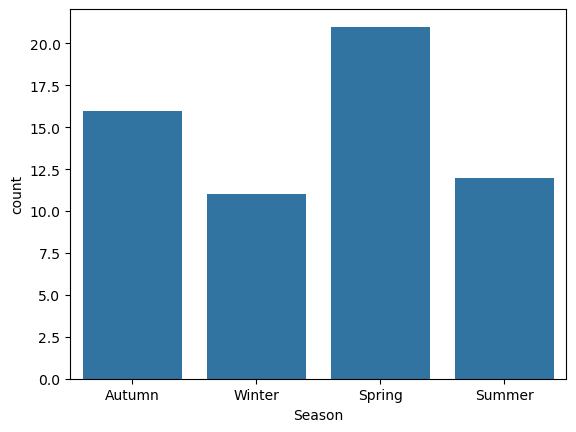

In [29]:

sns.countplot(data=df_removed_percent[df_removed_percent['Temperature'] > 69], x='Season')#Looking at this we can safely assume that the tempeeratures above 69 degrees celcius belong randomly to the seasons

<Axes: xlabel='Weather Type', ylabel='count'>

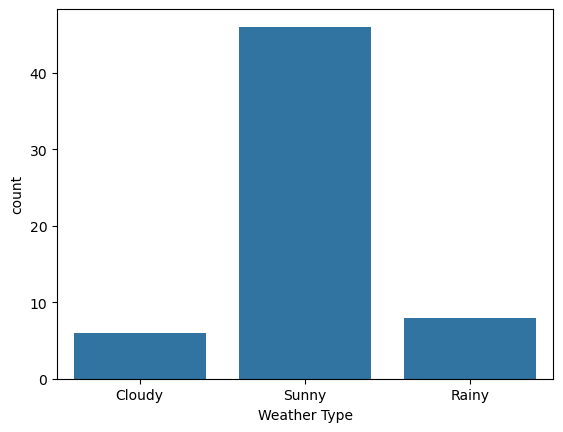

In [30]:

sns.countplot(data=df_removed_percent[df_removed_percent['Temperature'] > 69], x='Weather Type')#Looking at this we can safely assume that the tempeeratures above 69 degrees celcius majorityly belong to the weather type 'Sunny'

In [31]:
df_removed_percent = df_removed_percent[df_removed_percent['Temperature'] <= 69]#This is used to remove the rows that exceed 69 degrees celcius

In [32]:
weather_type_count = df_removed_percent['Weather Type'].value_counts()#This is used to fact check I did not lose too much data that it causes a certain weather type to be significantly more less than the others
print(weather_type_count)# As seen below the difference between the weather types is not significant and miniscule be it difference being only around 60 rows at max as such we can proceed with the data cleaning

Weather Type
Snowy     3130
Cloudy    3107
Rainy     3106
Sunny     3078
Name: count, dtype: int64


# Dealing with the realism
## [Assuming temperature recorded is 'air' temperature and not 'ground' temperature]
### 1:According to the internet the highest known recorded 'air' temperature is 56.7 degrees Celcius, what we have clearly exceeds those temperture readings. Source: https://www.thoughtco.com/highest-temperature-ever-recorded-1435172

### 2:According to the internet the highest recorded 'air' temperature durng winter is 38 degrees Celcius. https://wmo.asu.edu/content/arctic-circle-highest-temperature#:~:text=GENEVA%2C%2014%20December%202021%20%28WMO%29%20-GENEVA%2C%20XX%20DECEMBER,Climate%20Extremes%20to%20keep%20track%20of%20climate%20change. 

In [33]:
df_removed_percent[(df_removed_percent['Temperature'] > 38) & (df_removed_percent['Season'] == 'Winter')].sort_values('Temperature', ascending=False) #These temperatures are too extreme and therefore need tobe removed

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
3668,68.0,84,8.0,92.0,clear,1011.47,6,Winter,5.5,coastal,Sunny
898,66.0,83,18.0,92.0,partly cloudy,999.46,14,Winter,3.0,coastal,Rainy
2421,65.0,81,7.5,77.0,clear,1010.83,11,Winter,7.5,coastal,Sunny
12816,65.0,83,23.5,78.0,partly cloudy,994.48,11,Winter,0.5,coastal,Rainy
4681,63.0,72,22.0,75.0,overcast,1013.21,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
5830,39.0,50,2.0,2.0,clear,1026.92,6,Winter,9.0,mountain,Sunny
8646,39.0,28,9.5,0.0,partly cloudy,1015.22,9,Winter,9.0,inland,Sunny
8432,39.0,41,1.5,10.0,clear,1010.84,11,Winter,6.5,inland,Sunny
11988,39.0,42,4.0,5.0,clear,1020.05,7,Winter,8.5,mountain,Sunny


In [34]:
df_removed_percent = df_removed_percent[~((df_removed_percent['Temperature'] > 38) & (df_removed_percent['Season'] == 'Winter'))]

# Handling Wind Speed


In [35]:
Q1 = np.percentile(df_removed_percent['Wind Speed'], 25)
Q3 = np.percentile(df_removed_percent['Wind Speed'], 75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(f"IQR: {IQR:.2f}")
print(f"Lower Whisker: {lower_whisker:.2f}")
print(f"Upper Whisker: {upper_whisker:.2f}")

IQR: 8.00
Lower Whisker: -7.00
Upper Whisker: 25.00


In [36]:
rows_above_25 = df_removed_percent[df_removed_percent['Wind Speed'] > 25]
rows_below_minus_7 = df_removed_percent[df_removed_percent['Wind Speed'] < 0]

print(f"Rows with wind speeds above 25: {len(rows_above_25)}")
print(rows_above_25)

print("\nRows with wind speeds below -7:")#As can be seen no anomalies here as you physically cant have negative wind speeds.
print(rows_below_minus_7)

Rows with wind speeds above 25: 246
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
36            11.0        90        25.5               76.0  partly cloudy   
63             3.0        75        46.5               87.0       overcast   
90            15.0        81        28.5               71.0  partly cloudy   
123           -3.0        92        28.0               99.0  partly cloudy   
208           34.0        99        34.0               74.0  partly cloudy   
...            ...       ...         ...                ...            ...   
12999         -2.0        90        28.5               84.0       overcast   
13033         -2.0       100        26.0               87.0       overcast   
13076         25.0        75        26.0               80.0  partly cloudy   
13115         40.0        75        26.5               78.0  partly cloudy   
13176         19.0       100        36.0               86.0       overcast   

       Atmospheric Pressure

In [37]:
df_removed_percent[df_removed_percent['Wind Speed'] > 25].sort_values('Wind Speed', ascending=False)#These windspeeds are pretty high and are not realistic, HOWEVER, since the dataset is based on weather types, it is possible that these values are outliers but are still possible in the real world. 
#The data shows 261 rows which is a significant amount that cannot be ignored. As such I cannot simply remove the outliers.

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
12016,-2.0,91,48.5,89.0,overcast,984.91,5,Winter,3.0,mountain,Snowy
10872,20.0,78,47.0,76.0,overcast,1017.71,9,Autumn,0.5,mountain,Rainy
63,3.0,75,46.5,87.0,overcast,996.85,5,Winter,4.5,inland,Snowy
8016,-6.0,70,46.5,89.0,overcast,998.27,0,Winter,1.5,mountain,Snowy
2774,34.0,92,46.5,72.0,overcast,991.43,14,Winter,1.5,inland,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
1819,1.0,85,25.5,97.0,overcast,994.18,9,Winter,3.5,mountain,Snowy
2063,33.0,78,25.5,98.0,overcast,1001.14,3,Autumn,2.5,mountain,Rainy
2532,39.0,76,25.5,76.0,partly cloudy,1004.76,11,Autumn,1.5,mountain,Cloudy
9876,18.0,96,25.5,93.0,overcast,1011.32,14,Spring,1.0,coastal,Rainy


# Things to note with windspeed
## Outlier Exceptions
### 1:High windspeeds in mountain location is acceptable source:https://www.2news.com/strong-mountain-winds-explained/article_771ee50f-a3b2-52d5-b2ec-198beabe37e7.html 
![Windspeed](wind_speed.png)

### 2:Slightly fast wind speeds in coastal locations source:https://globalwindatlas.info/en
![coastal](coastal_wind.png)



<Axes: xlabel='Weather Type', ylabel='count'>

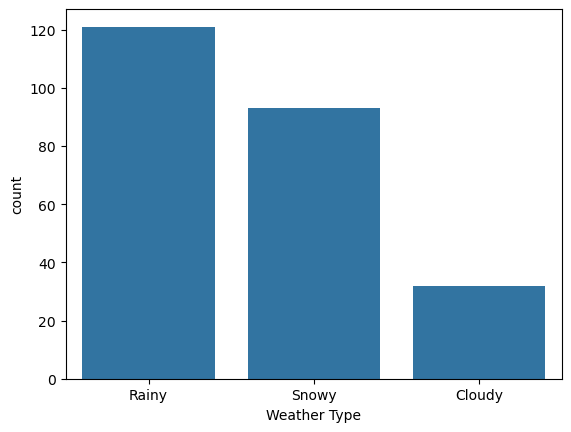

In [38]:
sns.countplot(data=df_removed_percent[df_removed_percent['Wind Speed'] > 25], x='Weather Type')
#The majority of the rows with wind speeds above 25 belong to the weather type 'Rainy' which means if i remove these outlier it may result in, the weather type 'Rainy' being underrepresented in the dataset
#I also noticed that a certain weather type is missing, which is 'sunny'.

In [39]:
df_removed_percent[(df_removed_percent['Wind Speed'] > 25) & (df_removed_percent['Weather Type'] == 'Sunny')] 
#This just further that the weather type 'Sunny' is missing in the dataset when wind speeds are above 25

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type


<Axes: xlabel='Season', ylabel='count'>

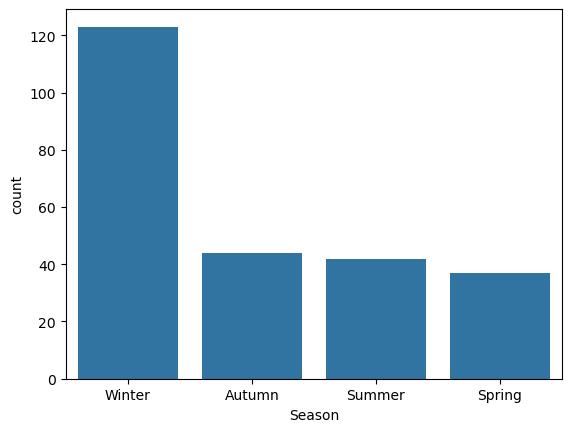

In [40]:

sns.countplot(data=df_removed_percent[df_removed_percent['Wind Speed'] > 25], x='Season')

In [41]:
df_removed_percent[(df_removed_percent['Wind Speed'] > 25) & (df_removed_percent['Season'] == 'Winter')]

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
36,11.0,90,25.5,76.0,partly cloudy,996.17,0,Winter,1.0,mountain,Rainy
63,3.0,75,46.5,87.0,overcast,996.85,5,Winter,4.5,inland,Snowy
90,15.0,81,28.5,71.0,partly cloudy,1008.00,4,Winter,6.0,inland,Cloudy
123,-3.0,92,28.0,99.0,partly cloudy,987.70,1,Winter,4.5,mountain,Snowy
241,22.0,95,35.5,87.0,overcast,998.45,11,Winter,4.0,coastal,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
12708,14.0,85,27.5,85.0,overcast,1005.20,2,Winter,5.0,coastal,Rainy
12782,-2.0,99,31.5,89.0,overcast,991.12,4,Winter,0.5,mountain,Snowy
12889,2.0,80,28.0,96.0,overcast,985.28,11,Winter,0.5,mountain,Snowy
12999,-2.0,90,28.5,84.0,overcast,992.14,14,Winter,4.5,mountain,Snowy


In [42]:
df_removed_percent = df_removed_percent[~((df_removed_percent['Wind Speed'] > 25) & (df_removed_percent['Location'] == 'inland'))]
#This is used to remove the rows that exceed 25 in wind speed whose location is inland
df_removed_percent[df_removed_percent['Wind Speed'] > 25].sort_values('Wind Speed', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
12016,-2.0,91,48.5,89.0,overcast,984.91,5,Winter,3.0,mountain,Snowy
10872,20.0,78,47.0,76.0,overcast,1017.71,9,Autumn,0.5,mountain,Rainy
8016,-6.0,70,46.5,89.0,overcast,998.27,0,Winter,1.5,mountain,Snowy
8458,38.0,86,45.0,72.0,partly cloudy,1007.42,1,Winter,2.0,coastal,Rainy
907,24.0,88,44.5,76.0,partly cloudy,1005.61,1,Spring,1.5,coastal,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
2532,39.0,76,25.5,76.0,partly cloudy,1004.76,11,Autumn,1.5,mountain,Cloudy
2063,33.0,78,25.5,98.0,overcast,1001.14,3,Autumn,2.5,mountain,Rainy
1819,1.0,85,25.5,97.0,overcast,994.18,9,Winter,3.5,mountain,Snowy
9876,18.0,96,25.5,93.0,overcast,1011.32,14,Spring,1.0,coastal,Rainy


Mean Wind Speed: 9.115597175314706
Median Wind Speed: 8.5
Percentiles:
0.25     5.0
0.50     8.5
0.75    12.5
0.95    18.5
Name: Wind Speed, dtype: float64


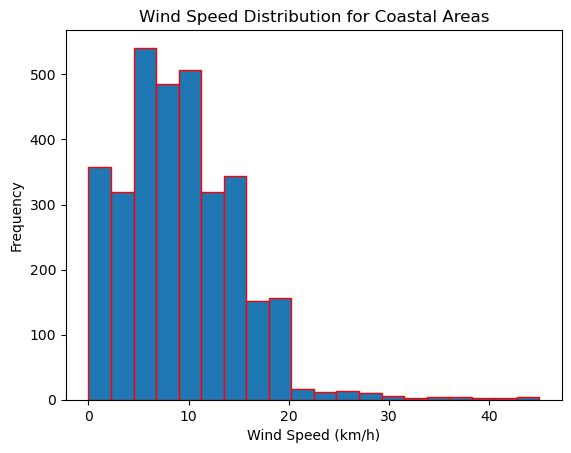

In [43]:

coastal_wind_speeds = df_removed_percent[df_removed_percent['Location'] == 'coastal']['Wind Speed']
mean_wind_speed = coastal_wind_speeds.mean()
median_wind_speed = coastal_wind_speeds.median()
percentiles = coastal_wind_speeds.quantile([0.25, 0.5, 0.75, 0.95])

print(f"Mean Wind Speed: {mean_wind_speed}")
print(f"Median Wind Speed: {median_wind_speed}")
print(f"Percentiles:\n{percentiles}")

# Visualize the distribution
plt.hist(coastal_wind_speeds, bins=20, edgecolor='red')
plt.title('Wind Speed Distribution for Coastal Areas')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Frequency')
plt.show()

In [44]:
df_removed_percent[(df_removed_percent['Wind Speed'] > 25) & (df_removed_percent['Location'] == 'coastal')].sort_values('Wind Speed', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
8458,38.0,86,45.0,72.0,partly cloudy,1007.42,1,Winter,2.0,coastal,Rainy
907,24.0,88,44.5,76.0,partly cloudy,1005.61,1,Spring,1.5,coastal,Rainy
3415,19.0,74,44.0,83.0,overcast,1010.35,14,Summer,1.0,coastal,Rainy
10494,47.0,87,43.0,78.0,partly cloudy,994.53,9,Autumn,3.0,coastal,Rainy
4900,19.0,98,41.5,81.0,overcast,1009.46,12,Summer,5.0,coastal,Rainy
3390,42.0,90,41.0,89.0,overcast,1003.01,6,Spring,4.0,coastal,Rainy
9127,28.0,70,39.0,80.0,overcast,1005.48,13,Spring,0.5,coastal,Rainy
5960,36.0,89,39.0,88.0,overcast,1002.66,0,Summer,2.5,coastal,Rainy
11039,22.0,97,38.0,83.0,overcast,1014.51,12,Summer,1.5,coastal,Rainy
6411,42.0,94,37.5,90.0,partly cloudy,1013.10,7,Summer,0.5,coastal,Rainy


In [45]:
df_removed_percent = df_removed_percent[~((df_removed_percent['Wind Speed'] > 30) & (df_removed_percent['Location'] == 'coastal'))]
#This is used to remove the rows that exceed 35.5 in wind speed whose location is coastal
df_removed_percent[df_removed_percent['Wind Speed'] > 25].sort_values('Wind Speed', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
12016,-2.0,91,48.5,89.0,overcast,984.91,5,Winter,3.0,mountain,Snowy
10872,20.0,78,47.0,76.0,overcast,1017.71,9,Autumn,0.5,mountain,Rainy
8016,-6.0,70,46.5,89.0,overcast,998.27,0,Winter,1.5,mountain,Snowy
2963,17.0,95,43.5,86.0,partly cloudy,1001.17,4,Winter,0.5,mountain,Rainy
8043,-8.0,99,43.0,79.0,partly cloudy,999.88,13,Winter,3.5,mountain,Snowy
...,...,...,...,...,...,...,...,...,...,...,...
7158,47.0,82,25.5,96.0,overcast,1006.85,5,Summer,1.0,coastal,Rainy
6169,51.0,82,25.5,88.0,overcast,1009.75,10,Summer,2.5,mountain,Cloudy
2532,39.0,76,25.5,76.0,partly cloudy,1004.76,11,Autumn,1.5,mountain,Cloudy
5009,16.0,97,25.5,91.0,partly cloudy,1014.79,5,Winter,9.5,coastal,Cloudy


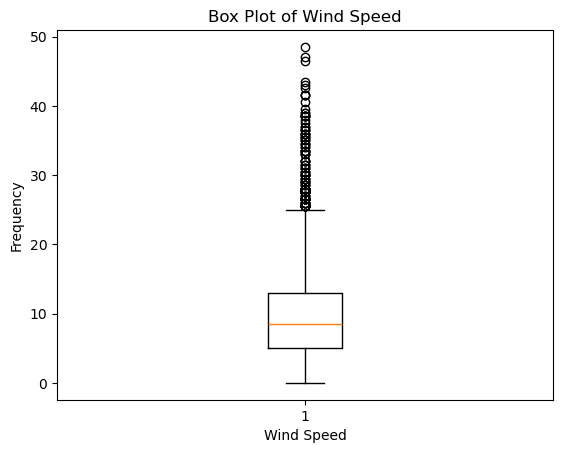

In [46]:
plt.boxplot(df_removed_percent['Wind Speed'])
plt.title('Box Plot of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()
#These outlier are within acceptable limits and do not quanitfy enough to be removed

# Things to note with windspeed with regards to 'sunny' weather type
## Foreground knowledge:
## Thermal Circulation
### During sunny days, the ground heats up due to solar radiation. Warm air rises from the surface, creating an area of low pressure.Cooler air from surrounding regions flows in to replace the rising warm air. This movement of air is known as thermal circulation. However, thermal circulation tends to be slower than other wind patterns because it occurs on a smaller scale and is influenced by local heating and cooling
### sources:
### 1:https://www.weather.gov/media/zhu/ZHU_Training_Page/winds/atmospheric_circulations/Atmospheric_Circulations.pdf
### 2:https://weather.com/science/weather-explainers/news/common-weather-terms-used-incorrectly
### 3:https://www.snexplores.org/article/explainer-winds-and-where-they-come 
### 4: Copilot https://www.microsoft.com/en-us/microsoft-copilot?msockid=25fdc8bd416d61241491dcde40286011 

# Handling Atmospheric Pressure

In [47]:
Q1 = np.percentile(df_removed_percent['Atmospheric Pressure'], 25)
Q3 = np.percentile(df_removed_percent['Atmospheric Pressure'], 75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(f"IQR: {IQR:.2f}")
print(f"Lower Whisker: {lower_whisker:.2f}")
print(f"Upper Whisker: {upper_whisker:.2f}")

IQR: 22.13
Lower Whisker: 961.34
Upper Whisker: 1049.86


In [48]:
df_removed_percent.sort_values('Atmospheric Pressure', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
4392,43.0,37,7.5,97.0,partly cloudy,1199.21,3,Spring,12.5,mountain,Snowy
11609,20.0,42,6.0,20.0,cloudy,1198.97,10,Spring,8.5,mountain,Snowy
9359,-14.0,44,8.5,55.0,partly cloudy,1198.85,0,Summer,12.0,coastal,Rainy
6834,8.0,54,10.5,86.0,overcast,1198.41,9,Autumn,11.5,inland,Sunny
11765,0.0,60,6.5,89.0,overcast,1197.92,14,Autumn,19.0,coastal,Snowy
...,...,...,...,...,...,...,...,...,...,...,...
2652,7.0,51,9.0,31.0,cloudy,801.25,8,Summer,4.0,mountain,Sunny
7287,-9.0,59,0.5,10.0,cloudy,800.83,4,Autumn,15.5,mountain,Sunny
2394,9.0,76,11.0,75.0,cloudy,800.82,3,Summer,6.0,mountain,Sunny
1478,35.0,25,1.5,94.0,cloudy,800.23,4,Spring,5.0,coastal,Snowy


# Dealing with Realism
### The lowest recorded barometic pressure was 870hPa clearly ours beats it but a milestone source:https://www.guinnessworldrecords.com/world-records/lowest-barometric-pressure
### The highest recorded barometic pressure was 1083hPa source:https://www.guinnessworldrecords.com/world-records/highest-barometric-pressure-/

In [49]:
df_removed_percent = df_removed_percent[(df_removed_percent['Atmospheric Pressure'] >= lower_whisker) & (df_removed_percent['Atmospheric Pressure'] <= upper_whisker)]

df_removed_percent.sort_values('Atmospheric Pressure', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
12570,15.0,68,3.5,57.0,overcast,1049.56,9,Summer,18.0,mountain,Sunny
12837,-4.0,62,3.5,14.0,partly cloudy,1049.20,9,Spring,14.0,inland,Cloudy
12776,25.0,75,2.5,72.0,overcast,1048.27,9,Winter,19.0,inland,Rainy
1933,-6.0,24,9.0,47.0,partly cloudy,1047.84,1,Autumn,6.5,mountain,Sunny
2328,-16.0,57,5.5,97.0,overcast,1047.31,9,Summer,11.0,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
5665,-15.0,20,13.5,76.0,partly cloudy,963.25,13,Spring,14.5,coastal,Rainy
10597,22.0,44,10.0,40.0,overcast,963.20,14,Spring,11.5,inland,Rainy
7783,-19.0,35,14.5,54.0,overcast,962.88,6,Winter,0.5,coastal,Snowy
2712,6.0,69,6.5,31.0,cloudy,962.72,10,Winter,14.5,inland,Snowy


# Handling UV index

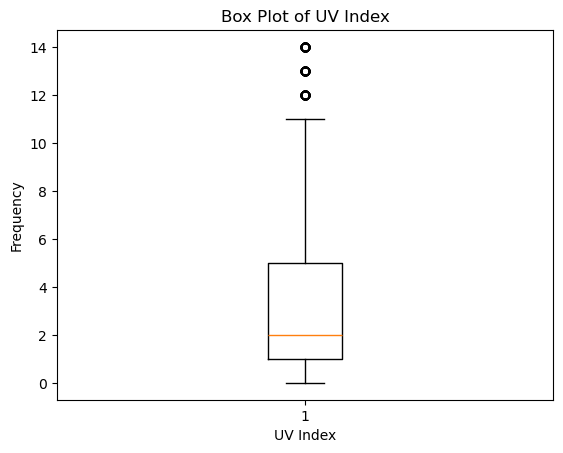

In [50]:
plt.boxplot(df_removed_percent['UV Index'])
plt.title('Box Plot of UV Index')
plt.xlabel('UV Index')
plt.ylabel('Frequency')
plt.show()

In [51]:

Q1 = np.percentile(df_removed_percent['UV Index'], 25)
Q3 = np.percentile(df_removed_percent['UV Index'], 75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(f"Upper Whisker: {upper_whisker:.2f}")
print(f"Lower Whisker: {lower_whisker:.2f}")
print(f"Interquartile Range: {IQR:.2f}")


Upper Whisker: 11.00
Lower Whisker: -5.00
Interquartile Range: 4.00


In [52]:
df_removed_percent[df_removed_percent['UV Index'] > upper_whisker].sort_values('UV Index', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
7122,32.0,91,5.5,100.0,partly cloudy,1024.13,14,Winter,7.0,mountain,Sunny
4112,13.0,80,16.5,93.0,overcast,1003.40,14,Summer,1.5,inland,Cloudy
9831,0.0,72,14.5,85.0,overcast,985.71,14,Winter,4.5,inland,Snowy
9876,18.0,96,25.5,93.0,overcast,1011.32,14,Spring,1.0,coastal,Rainy
4417,17.0,92,20.5,70.0,partly cloudy,1013.39,14,Autumn,7.5,inland,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...
10324,20.0,77,24.5,73.0,overcast,1007.62,12,Spring,4.5,inland,Cloudy
7952,33.0,98,12.5,85.0,clear,1025.58,12,Summer,8.5,mountain,Sunny
10123,66.0,83,16.0,70.0,partly cloudy,1019.52,12,Summer,6.5,mountain,Sunny
10121,34.0,97,20.0,99.0,clear,1020.23,12,Autumn,5.5,mountain,Sunny


# Dealing with Realism
### The UV index normally ranges from 0-11
### for the outliers in which UV index falls out of this range, with it being 12-14. It most likely is due to event-based causes, for example a solar eclipse. typically in these situations the weather type is 'sunny'

In [53]:
df_removed_percent.loc[df_removed_percent['UV Index'] > 11, 'Weather Type'] = 'Sunny'
df_removed_percent[df_removed_percent['UV Index'] > 11]

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
33,15.0,97,23.0,91.0,overcast,1009.36,13,Winter,2.5,mountain,Sunny
99,31.0,72,17.0,96.0,partly cloudy,1013.85,13,Winter,3.5,inland,Sunny
221,63.0,86,13.0,75.0,clear,1027.31,14,Summer,2.5,coastal,Sunny
316,51.0,85,13.5,77.0,clear,1025.39,12,Autumn,5.0,mountain,Sunny
413,31.0,96,14.5,92.0,overcast,1000.22,12,Summer,10.0,mountain,Sunny
...,...,...,...,...,...,...,...,...,...,...,...
12848,11.0,74,10.0,70.0,clear,1023.33,14,Spring,12.0,coastal,Sunny
12871,20.0,38,4.5,17.0,overcast,1022.79,14,Winter,17.5,mountain,Sunny
12877,40.0,41,5.5,52.0,cloudy,1033.78,14,Autumn,16.0,coastal,Sunny
12999,-2.0,90,28.5,84.0,overcast,992.14,14,Winter,4.5,mountain,Sunny


# Handling Visibility

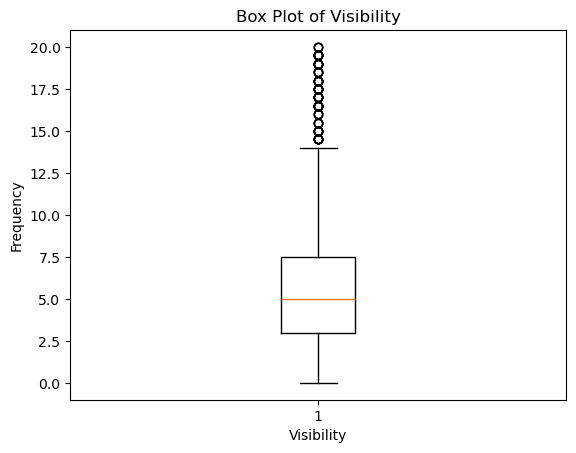

In [54]:
plt.boxplot(df_removed_percent['Visibility (km)'])
plt.title('Box Plot of Visibility')
plt.xlabel('Visibility')
plt.ylabel('Frequency')
plt.show()

In [55]:

Q1 = np.percentile(df_removed_percent['Visibility (km)'], 25)
Q3 = np.percentile(df_removed_percent['Visibility (km)'], 75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(f"Upper Whisker: {upper_whisker:.2f}")
print(f"Lower Whisker: {lower_whisker:.2f}")
print(f"Interquartile Range: {IQR:.2f}")

Upper Whisker: 14.25
Lower Whisker: -3.75
Interquartile Range: 4.50


In [56]:
df_removed_percent[df_removed_percent['Visibility (km)'] > upper_whisker].sort_values('Visibility (km)', ascending=False)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
11733,18.0,20,6.0,15.0,cloudy,1011.20,12,Winter,20.0,coastal,Sunny
4738,24.0,74,5.5,73.0,partly cloudy,1011.73,11,Winter,20.0,inland,Snowy
2277,17.0,72,12.0,46.0,partly cloudy,990.66,10,Spring,20.0,inland,Sunny
9097,-8.0,61,15.0,83.0,cloudy,991.55,8,Spring,19.5,coastal,Cloudy
3288,19.0,29,6.0,84.0,partly cloudy,984.17,2,Winter,19.5,mountain,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...
4644,-16.0,20,3.5,35.0,overcast,1029.27,6,Summer,14.5,coastal,Sunny
6043,37.0,37,5.5,29.0,overcast,965.32,3,Spring,14.5,inland,Snowy
10070,54.0,91,2.0,71.0,clear,1022.48,1,Autumn,14.5,coastal,Sunny
5665,-15.0,20,13.5,76.0,partly cloudy,963.25,13,Spring,14.5,coastal,Sunny


In [57]:
df_removed_percent[df_removed_percent['Visibility (km)'] > lower_whisker].sort_values('Visibility (km)', ascending=True)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
528,-16.0,98,4.5,73.0,overcast,994.10,0,Winter,0.0,inland,Snowy
584,6.0,76,2.5,64.0,partly cloudy,1000.66,6,Spring,0.0,inland,Snowy
11233,29.0,29,8.5,63.0,overcast,998.67,1,Summer,0.0,mountain,Cloudy
10848,2.0,95,1.5,74.0,overcast,993.99,12,Winter,0.0,mountain,Sunny
12253,63.0,98,26.5,97.0,overcast,1011.04,5,Spring,0.0,coastal,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
9097,-8.0,61,15.0,83.0,cloudy,991.55,8,Spring,19.5,coastal,Cloudy
11206,45.0,32,11.5,55.0,overcast,1024.35,3,Summer,19.5,mountain,Snowy
2277,17.0,72,12.0,46.0,partly cloudy,990.66,10,Spring,20.0,inland,Sunny
11733,18.0,20,6.0,15.0,cloudy,1011.20,12,Winter,20.0,coastal,Sunny


 [red] Mean Visibility: 5.17 km
 [yellow] Standard Deviation of Visibility: 2.80 km
 [green] Upper Whisker: 14.25 km
 [green] Lower Whisker: -3.75 km


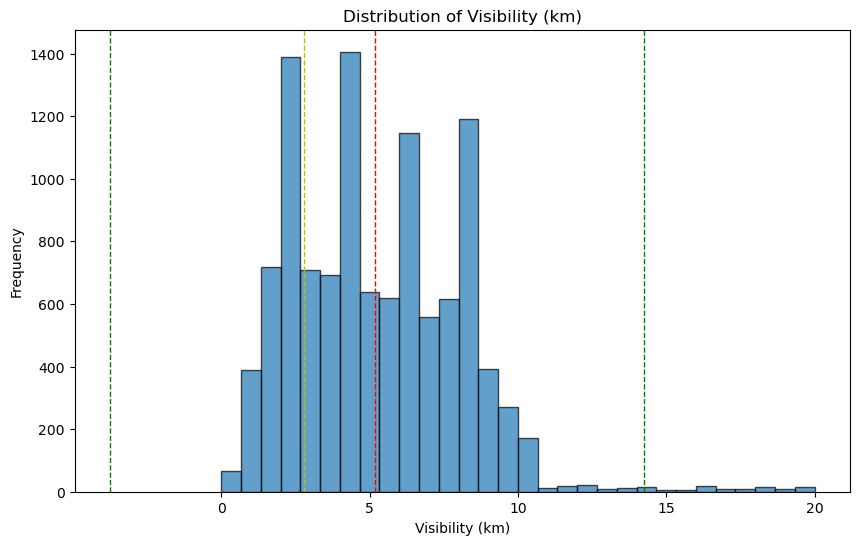

In [58]:
from numpy import std


mean_visibility = df_removed_percent['Visibility (km)'].mean()
std_visibility = df_removed_percent['Visibility (km)'].std()

print(f" [red] Mean Visibility: {mean_visibility:.2f} km")
print(f" [yellow] Standard Deviation of Visibility: {std_visibility:.2f} km")
print(f" [green] Upper Whisker: {upper_whisker:.2f} km")
print(f" [green] Lower Whisker: {lower_whisker:.2f} km")

plt.figure(figsize=(10, 6))
plt.hist(df_removed_percent['Visibility (km)'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_whisker, color='g', linestyle='dashed', linewidth=1)
plt.axvline(std_visibility, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mean_visibility, color='r', linestyle='dashed', linewidth=1)
plt.axvline(upper_whisker, color='g', linestyle='dashed', linewidth=1)
plt.title('Distribution of Visibility (km)')
plt.xlabel('Visibility (km)')
plt.ylabel('Frequency')
plt.show()

In [59]:
df_removed_percent = df_removed_percent[df_removed_percent['Visibility (km)'] <= upper_whisker]#I decided to just remove the outliers as I have no foreground knowledge of visibility in the real world
df_removed_percent[df_removed_percent['Visibility (km)'] > upper_whisker].sort_values('Visibility (km)', ascending=True)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type


# Feature Engineering
### Ideas taken from Umer Naeem source: https://www.kaggle.com/code/umerrtx/eda-feature-eng-xgb-accuracy-93-20 

# Combining temperature feature and humidity feature to form heat index source: https://www.calculator.net/heat-index-calculator.html

![heat_index](heat_index.png)

In [60]:
df_removed_percent['heat_index'] = -42.379 + 2.04901523 * df_removed_percent['Temperature'] + 10.14333127 * df_removed_percent['Humidity'] - 0.22475541 * df_removed_percent['Temperature'] * df_removed_percent['Humidity'] - 6.83783e-03 * df_removed_percent['Temperature']**2 - 5.481717e-02 * df_removed_percent['Humidity']**2 + 1.22874e-03 * df_removed_percent['Temperature']**2 * df_removed_percent['Humidity'] + 8.5282e-04 * df_removed_percent['Temperature'] * df_removed_percent['Humidity']**2 - 1.99e-06 * df_removed_percent['Temperature']**2 * df_removed_percent['Humidity']**2
removed_rows['heat_index'] = -42.379 + 2.04901523 * removed_rows['Temperature'] + 10.14333127 * removed_rows['Humidity'] - 0.22475541 * removed_rows['Temperature'] * removed_rows['Humidity'] - 6.83783e-03 * removed_rows['Temperature']**2 - 5.481717e-02 * removed_rows['Humidity']**2 + 1.22874e-03 * removed_rows['Temperature']**2 * removed_rows['Humidity'] + 8.5282e-04 * removed_rows['Temperature'] * removed_rows['Humidity']**2 - 1.99e-06 * removed_rows['Temperature']**2 * removed_rows['Humidity']**2
print(df_removed_percent.head())

   Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0        73         9.5               82.0  partly cloudy   
1         39.0        96         8.5               71.0  partly cloudy   
2         30.0        64         7.0               16.0          clear   
3         38.0        83         1.5               82.0          clear   
4         27.0        74        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0               1010.82         2  Winter              3.5    inland   
1               1011.43         7  Spring             10.0    inland   
2               1018.72         5  Spring              5.5  mountain   
3               1026.25         7  Spring              1.0   coastal   
4                990.67         1  Winter              2.5  mountain   

  Weather Type  heat_index  
0        Rainy  282.737231  
1       Cloudy  112.257542  
2        Sunny  174.283105  
3     

# Combining temperature feature and wind speed feature to form wind chill source: https://www.calculator.net/wind-chill-calculator.html
![wind_chill](wind-chill.png)

In [61]:
df_removed_percent['Wind_chill'] = 13.12 + 0.6215 * df_removed_percent['Temperature'] - 11.37 * df_removed_percent['Wind Speed']**0.16 + 0.3965 * df_removed_percent['Temperature'] * df_removed_percent['Wind Speed']**0.16
removed_rows['Wind_chill'] = 13.12 + 0.6215 * removed_rows['Temperature'] - 11.37 * removed_rows['Wind Speed']**0.16 + 0.3965 * removed_rows['Temperature'] * removed_rows['Wind Speed']**0.16
print(df_removed_percent.tail())

       Temperature  Humidity  Wind Speed  Precipitation (%) Cloud Cover  \
13194         29.0        62        13.0               17.0    overcast   
13195         10.0        74        14.5               71.0    overcast   
13197         30.0        77         5.5               28.0    overcast   
13198          3.0        76        10.0               94.0    overcast   
13199         -5.0        38         0.0               92.0    overcast   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
13194               1002.81         2  Spring              5.0   coastal   
13195               1003.15         1  Summer              1.0  mountain   
13197               1012.69         3  Autumn              9.0   coastal   
13198                984.27         0  Winter              2.0    inland   
13199               1015.37         5  Autumn             10.0  mountain   

      Weather Type  heat_index  Wind_chill  
13194       Cloudy  178.055580   31.337202  
13

# Binning

In [62]:
# Define the bin ranges and labels
import re


bins = [0, 2, 5, 7, 10, np.inf]
labels = ['Low', 'Moderate', 'High', 'Very High', 'Extreme']

# Bin the UV index column
df_removed_percent['UV Index Range'] = pd.cut(df_removed_percent['UV Index'], bins=bins, labels=labels, right=False)
removed_rows['UV Index Range'] = pd.cut(removed_rows['UV Index'], bins=bins, labels=labels, right=False)
# Print the updated dataframe
print(df_removed_percent.head())

   Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0        73         9.5               82.0  partly cloudy   
1         39.0        96         8.5               71.0  partly cloudy   
2         30.0        64         7.0               16.0          clear   
3         38.0        83         1.5               82.0          clear   
4         27.0        74        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0               1010.82         2  Winter              3.5    inland   
1               1011.43         7  Spring             10.0    inland   
2               1018.72         5  Spring              5.5  mountain   
3               1026.25         7  Spring              1.0   coastal   
4                990.67         1  Winter              2.5  mountain   

  Weather Type  heat_index  Wind_chill UV Index Range  
0        Rainy  282.737231   13.478732       Moderate  
1       Cl

# One-hot Encoding

In [63]:
categorical_cols = ['Cloud Cover', 'Season', 'Location', 'Weather Type', 'UV Index Range']
df_encoded = pd.get_dummies(df_removed_percent, columns=categorical_cols)
removed_rows=pd.get_dummies(removed_rows, columns=categorical_cols)
df_encoded.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),heat_index,Wind_chill,Cloud Cover_clear,...,Location_mountain,Weather Type_Cloudy,Weather Type_Rainy,Weather Type_Snowy,Weather Type_Sunny,UV Index Range_Low,UV Index Range_Moderate,UV Index Range_High,UV Index Range_Very High,UV Index Range_Extreme
0,14.0,73,9.5,82.0,1010.82,2,3.5,282.737231,13.478732,False,...,False,False,True,False,False,False,True,False,False,False
1,39.0,96,8.5,71.0,1011.43,7,10.0,112.257542,43.123533,False,...,False,True,False,False,False,False,False,False,True,False
2,30.0,64,7.0,16.0,1018.72,5,5.5,174.283105,32.481762,True,...,True,False,False,False,True,False,False,True,False,False
3,38.0,83,1.5,82.0,1026.25,7,1.0,131.716117,40.681791,True,...,False,False,False,False,True,False,False,False,True,False
4,27.0,74,17.0,66.0,990.67,1,2.5,193.758678,28.854897,False,...,True,False,True,False,False,True,False,False,False,False


In [64]:
removed_rows.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),heat_index,Wind_chill,Cloud Cover_overcast,...,Season_Autumn,Season_Spring,Location_coastal,Location_inland,Weather Type_Rainy,UV Index Range_Low,UV Index Range_Moderate,UV Index Range_High,UV Index Range_Very High,UV Index Range_Extreme
9752,30.0,99,11.5,78.0,1005.65,3,3.5,155.022362,32.541017,True,...,False,True,False,True,True,False,True,False,False,False
4814,18.0,96,13.0,55.0,1004.65,2,4.5,246.224457,17.926140,False,...,True,False,True,False,True,False,True,False,False,False


In [65]:
df_encoded = df_encoded.drop(columns=['Temperature', 'Wind Speed', 'Humidity', 'UV Index'])
removed_rows = removed_rows.drop(columns=['Temperature', 'Wind Speed', 'Humidity', 'UV Index'])
print(df_encoded.head())
print(removed_rows.head())


   Precipitation (%)  Atmospheric Pressure  Visibility (km)  heat_index  \
0               82.0               1010.82              3.5  282.737231   
1               71.0               1011.43             10.0  112.257542   
2               16.0               1018.72              5.5  174.283105   
3               82.0               1026.25              1.0  131.716117   
4               66.0                990.67              2.5  193.758678   

   Wind_chill  Cloud Cover_clear  Cloud Cover_cloudy  Cloud Cover_overcast  \
0   13.478732              False               False                 False   
1   43.123533              False               False                 False   
2   32.481762               True               False                 False   
3   40.681791               True               False                 False   
4   28.854897              False               False                  True   

   Cloud Cover_partly cloudy  Season_Autumn  ...  Location_mountain  \
0        

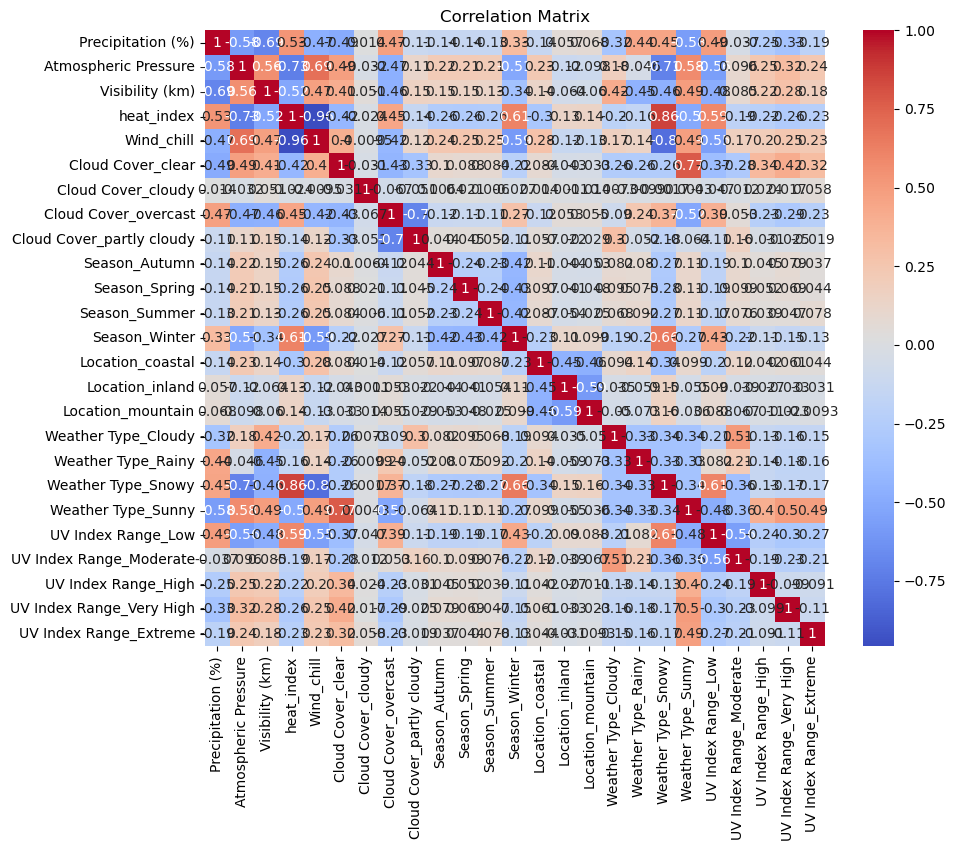

In [66]:


# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# MODEL

![Models List](machine_learning_models.png)

# Train Test Splitting

In [67]:

X = df_encoded.drop(columns=['Weather Type_Cloudy', 'Weather Type_Rainy', 'Weather Type_Snowy', 'Weather Type_Sunny'])#This is used to drop the target features
y = df_encoded[['Weather Type_Cloudy', 'Weather Type_Rainy', 'Weather Type_Snowy', 'Weather Type_Sunny']]#This is used to get the target features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#This shuffles the data and splits it into training and testing data


In [68]:
print (X_train)


      Precipitation (%)  Atmospheric Pressure  Visibility (km)  heat_index  \
5502                4.0               1017.71             10.0  139.859623   
2987               95.0                985.57              4.0  682.944400   
7064               12.0               1020.80              9.5  182.704568   
5858               17.0               1023.21              9.0  150.075859   
7657               63.0                995.44              2.5  510.450251   
...                 ...                   ...              ...         ...   
6784               70.0               1008.62              2.0  293.604496   
6131               54.0                991.63              1.5  277.421245   
6362               58.0               1017.52              3.0  262.961963   
1032               64.0                991.54              2.0  398.772273   
8648               41.0               1015.13              5.0  160.645409   

      Wind_chill  Cloud Cover_clear  Cloud Cover_cloudy  Cloud 

# Random Forest Classifier

Accuracy: 0.97
Confusion Matrix:
[[538  13   1   5]
 [ 11 519   2   3]
 [  4   2 567   1]
 [  5   2   7 530]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.97      0.97       557
       Rainy       0.97      0.97      0.97       535
       Snowy       0.98      0.99      0.99       574
       Sunny       0.98      0.97      0.98       544

    accuracy                           0.97      2210
   macro avg       0.97      0.97      0.97      2210
weighted avg       0.97      0.97      0.97      2210



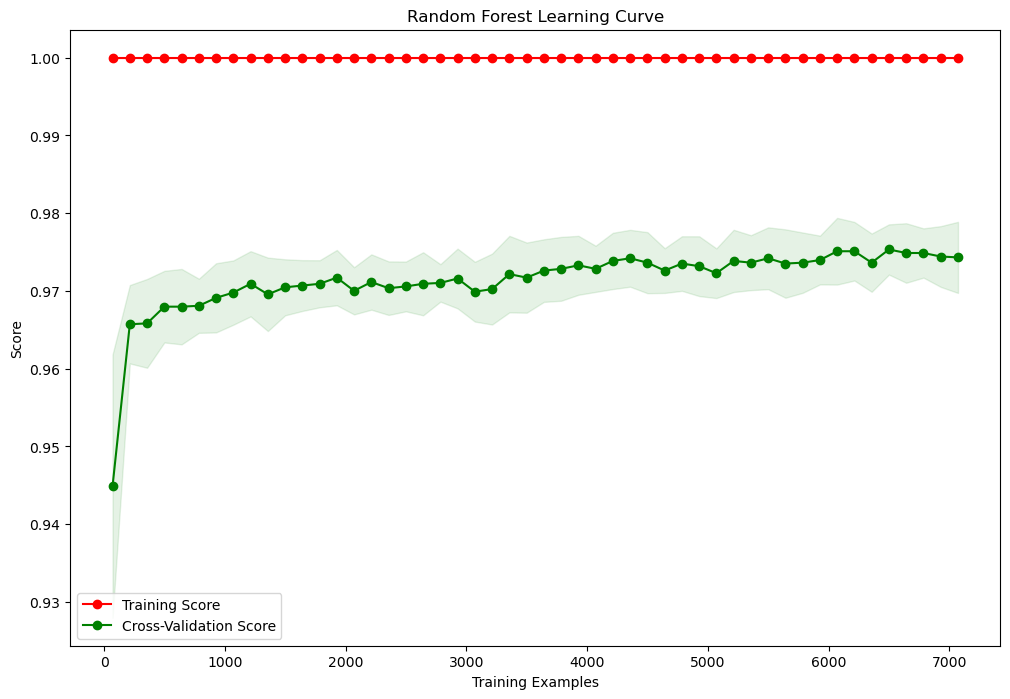

In [69]:
# Creating a Random Forest Classifier model
y_train_single=np.argmax(y_train.values, axis=1)
y_test_single=np.argmax(y_test.values, axis=1)
label_to_weather_type = {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}
rfc = ensemble.RandomForestClassifier(random_state=42)   
rfc.fit(X_train, y_train_single)
y_predictions = rfc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('Random Forest Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()



## In case Learning graph does not load
![rfc_image](cross-validate.png)
### A completely flat 100% Training score is too suspicious could be a sign of overfitting, however as previously shown multi-collinearity did not appear, no signs of data leakage

In [ ]:
print(f'y_train_single={y_train_single}')
print(f'y_test_single={y_test_single}')
print(f'y_train={y_train}')
print(f'ytest={y_test}')


# GradientboostingClassifier using Optuna

In [ ]:
start = time()
speed={}
model=ensemble.GradientBoostingClassifier()
def objective(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 50, 500),
        'max_depth':trial.suggest_int('max_depth', 3, 10),
        'min_samples_split':trial.suggest_int('min_samples_split', 2, 10),
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    }
    model.set_params(**params)
    return np.mean(cross_val_score(model, X_train, y_train_single, n_jobs=-1, cv=5, scoring='accuracy'))
study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
trial=study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
speed['GradientBoostingClassifier']=time()-start
#In case variable/ouput lost, Optuna said :[I 2024-07-26 00:00:32,736] Trial 99 finished with value: 0.9732999024345274 and parameters: {'n_estimators': 192, 'max_depth': 7, 'min_samples_split': 6, 'learning_rate': 0.010183446288329233}. Best is trial 95 with value: 0.9739786994855406. Accuracy: 0.9739786994855406 Best hyperparameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 9, 'learning_rate': 0.010016463771909026}


In [ ]:
gbc=ensemble.GradientBoostingClassifier(n_estimators=101,max_depth=7,min_samples_split=9,learning_rate=0.010016463771909026)
gbc.fit(X_train, y_train_single)
y_predictions = gbc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(gbc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('GBC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()



## In case GBC learning curve does not appear
![GBC_curve](gbc.png)
### the cross-validation score shows an initial sharp increase and then stabilizes.  it indicates that the validation dataset may be easier for the model to predict than the training dataset.

# SGDClassifier


In [ ]:
#Creating a SGDC Classifier model
start = time()
speed={}
model=SGDClassifier()
def objective(trial):
    params={
        'alpha':trial.suggest_float('alpha', 1e-5, 1e-1),
        'max_iter':trial.suggest_int('max_iter', 100, 1000),
        'loss':trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'])
    }
    model.set_params(**params)
    return np.mean(cross_val_score(model, X_train, y_train_single, n_jobs=-1, cv=5, scoring='accuracy'))
study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)
trial=study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
speed['SGDClassifier']=time()-start
#In case variable or ouput of the SGDC was lost,after 1000 trials optuna said: Accuracy: 0.8845998279160169 Best hyperparameters: {'alpha': 0.07389592365424383, 'max_iter': 930, 'loss': 'squared_hinge'}

In [ ]:
sgdc=SGDClassifier(alpha=0.07389592365424383,max_iter=930,loss='squared_hinge')
sgdc.fit(X_train, y_train_single)
y_predictions = sgdc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(sgdc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('SGDC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


![SGDC](sgdc.png)
### Based on the outcome shown it is too sporadic as this model is linear based as such is unable to figure out complex patterns

# KnearestneighboursClassifier tuning with grid search
### Sourced:https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py 

In [ ]:
# KNNClassifier
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]
)

In [ ]:
param_grid = {
    'knn__n_neighbors': range(1, 100)
}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")
#In case the output was lost, the best parameters were {'knn__n_neighbors': 3} and the best score was 0.9622121370423578

In [ ]:
clf = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=3))
    ]
)
clf.fit(X_train, y_train_single)
y_predictions = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('KNN Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()




Accuracy: 0.96
Confusion Matrix:
[[536  13   2   6]
 [ 19 507   5   4]
 [  1   5 566   2]
 [ 16   8   2 518]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.94      0.96      0.95       557
       Rainy       0.95      0.95      0.95       535
       Snowy       0.98      0.99      0.99       574
       Sunny       0.98      0.95      0.96       544

    accuracy                           0.96      2210
   macro avg       0.96      0.96      0.96      2210
weighted avg       0.96      0.96      0.96      2210

![KNN](knn.png)
### This learning curve shows a good gap between the 2 scores which means good fitting


# Gaussian Process Classifier tuned with Optuna

In [ ]:
#Gaussian Process Classifier
start = time()
speed={}
model=GaussianProcessClassifier()
def objective(trial):
    params={
        'n_restarts_optimizer':trial.suggest_int('n_restarts_optimizer', 0, 10)
    }
    model.set_params(**params)
    return np.mean(cross_val_score(model, X_train, y_train_single, n_jobs=-1, cv=5, scoring='accuracy'))
study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
trial=study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
speed['GaussianProcessClassifier']=time()-start
#In case the output was lost, Optuna said: Accuracy: 0.9280460401478079 Best hyperparameters: {'n_restarts_optimizer': 9}


In [ ]:

gpc=GaussianProcessClassifier(n_restarts_optimizer=9)
gpc.fit(X_train, y_train_single)
y_predictions = gpc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")



### In case output of report was lost
Accuracy: 0.92
Confusion Matrix:
[[502  20   0  35]
 [ 16 498   1  20]
 [  0   1 552  21]
 [ 27  22  14 481]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.92      0.90      0.91       557
       Rainy       0.92      0.93      0.93       535
       Snowy       0.97      0.96      0.97       574
       Sunny       0.86      0.88      0.87       544

    accuracy                           0.92      2210
   macro avg       0.92      0.92      0.92      2210
weighted avg       0.92      0.92      0.92      2210



In [ ]:
#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(gpc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('GPC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

 

![gpc](gpc.png)

# Decision Tree tuned using grid serch

In [ ]:
#Decision Tree Classifier tuned using grid search
dtc=DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}
grid_search = GridSearchCV(dtc, param_grid, cv=5)
grid_search.fit(X_train, y_train_single)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")
#In case the output was lost, the Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4} Best Score: 0.9734133447031679

Accuracy: 0.97
Confusion Matrix:
[[536  16   2   3]
 [  9 522   0   4]
 [  3   2 566   3]
 [  9   5   1 529]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.96      0.96       557
       Rainy       0.96      0.98      0.97       535
       Snowy       0.99      0.99      0.99       574
       Sunny       0.98      0.97      0.98       544

    accuracy                           0.97      2210
   macro avg       0.97      0.97      0.97      2210
weighted avg       0.97      0.97      0.97      2210



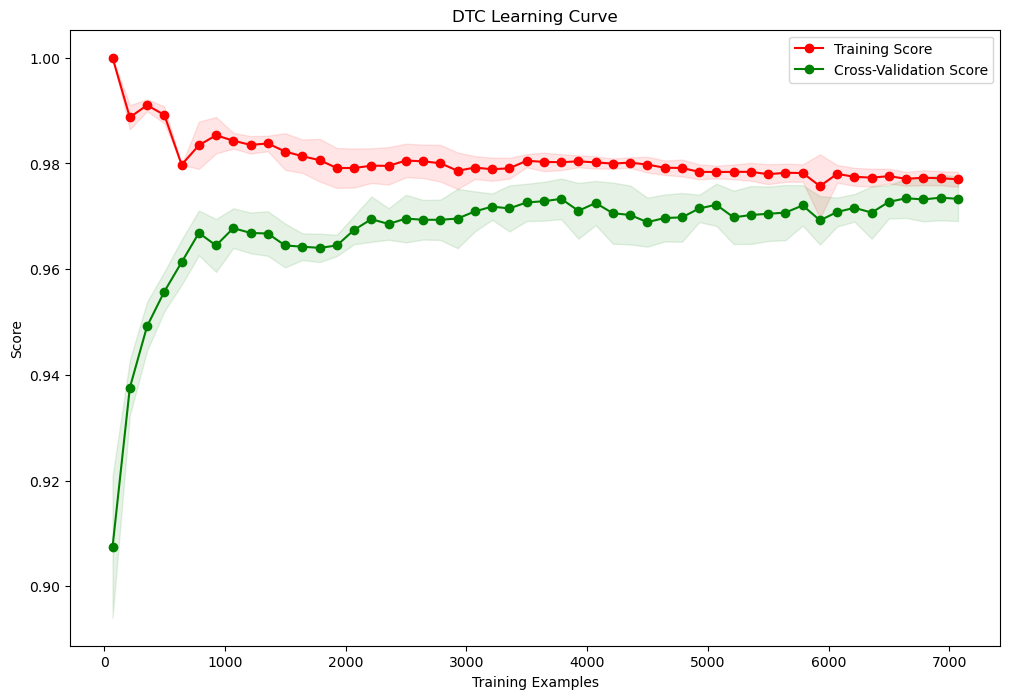

In [70]:
dtc=DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1,min_samples_split=4)
dtc.fit(X_train, y_train_single)
y_predictions = dtc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(dtc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('DTC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()



![decisionTree](dtc.png)

Accuracy: 0.97
Confusion Matrix:
[[536  16   2   3]
 [  9 522   0   4]
 [  3   2 566   3]
 [  9   5   1 529]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.96      0.96       557
       Rainy       0.96      0.98      0.97       535
       Snowy       0.99      0.99      0.99       574
       Sunny       0.98      0.97      0.98       544

    accuracy                           0.97      2210
   macro avg       0.97      0.97      0.97      2210
weighted avg       0.97      0.97      0.97      2210

# AdaBoost Classifier tuned with Optuna

In [ ]:
#AdaBoost Classifier tuned with Optuna


start = time()
speed={}
model=ensemble.AdaBoostClassifier()
def objective(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 50, 500),
        'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1,log=True)
    }
    model.set_params(**params)
    return np.mean(cross_val_score(model, X_train, y_train_single, n_jobs=-1, cv=5, scoring='accuracy'))
study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
trial=study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
speed['AdaBoostClassifier']=time()-start
#In case the output was lost, Optuna said: Accuracy: 0.9499948144335442 Best hyperparameters: {'n_estimators': 482, 'learning_rate': 0.09818031727057615}


In [ ]:
abc=ensemble.AdaBoostClassifier(n_estimators=482,learning_rate=0.09818031727057615)
abc.fit(X_train, y_train_single)
y_predictions = abc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(abc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)   

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('ABC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


Accuracy: 0.95
Confusion Matrix:
[[535  16   2   4]
 [  7 526   0   2]
 [  1   8 564   1]
 [ 41  13  16 474]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.92      0.96      0.94       557
       Rainy       0.93      0.98      0.96       535
       Snowy       0.97      0.98      0.98       574
       Sunny       0.99      0.87      0.92       544

    accuracy                           0.95      2210
   macro avg       0.95      0.95      0.95      2210
weighted avg       0.95      0.95      0.95      2210

![ada](abc.png)


# Support Vector Machine using optuna

In [ ]:
#Support Vector Classifier tuned with Optuna
start = time()
speed={}
model=SVC()
def objective(trial):
    params={
        'C':trial.suggest_float('C', 1e-5, 1e5, log=True),
        'kernel':trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree':trial.suggest_int('degree', 2, 5)
    }
    model.set_params(**params)
    return np.mean(cross_val_score(model, X_train, y_train_single, n_jobs=-1, cv=5, scoring='accuracy'))
study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
trial=study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
speed['SVC']=time()-start
#In case the output was lost, Optuna said:Accuracy: 0.9720556865818025 Best hyperparameters: {'C': 0.9857516900371581, 'kernel': 'linear', 'degree': 3}


In [ ]:
svc=SVC(C=0.9857516900371581,kernel='linear',degree=3)
svc.fit(X_train, y_train_single)
y_predictions = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_single, y_predictions)}")
print(f"Classification Report:\n{classification_report(y_test_single, y_predictions,target_names=[label_to_weather_type[i] for i in range(len(label_to_weather_type))])}")

#ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, y_train_single, cv=5, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title('SVC Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

Accuracy: 0.97
Confusion Matrix:
[[535  17   1   4]
 [  8 517   5   5]
 [  3   3 567   1]
 [  9   5   3 527]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.96      0.96       557
       Rainy       0.95      0.97      0.96       535
       Snowy       0.98      0.99      0.99       574
       Sunny       0.98      0.97      0.98       544

    accuracy                           0.97      2210
   macro avg       0.97      0.97      0.97      2210
weighted avg       0.97      0.97      0.97      2210

![svc](svc.png)

# Choosing the right model

In [ ]:
#Choosing the right model
models = {
    'Random Forest': rfc,
    'Gradient Boosting': gbc,
    'SGD Classifier': sgdc,
    'KNN Classifier': clf,
    'Gaussian Process': gpc,
    'Decision Tree': dtc,
    'AdaBoost': abc,
    'Support Vector Classifier': svc
}

for name, model in models.items():
    start = time()
    model.fit(X_train, y_train_single)
    y_predictions = model.predict(X_test)
    end = time()
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test_single, y_predictions):.2f}")
    print(f"Time: {end - start:.2f} seconds")
    print()



Model: Random Forest
Accuracy: 0.97
Time: 0.63 seconds

Model: Gradient Boosting
Accuracy: 0.97
Time: 10.03 seconds

Model: SGD Classifier
Accuracy: 0.72
Time: 0.25 seconds

Model: KNN Classifier
Accuracy: 0.96
Time: 0.10 seconds

Model: Gaussian Process
Accuracy: 0.92
Time: 127.82 seconds

Model: Decision Tree
Accuracy: 0.97
Time: 0.02 seconds

Model: AdaBoost
Accuracy: 0.95
Time: 2.71 seconds

Model: Support Vector Classifier
Accuracy: 0.97
Time: 8.00 seconds

# Model Chosen: Decision Tree Classifier
## Reasons behind model chosen
### 1:Fast and Accurate
Model: Decision Tree
Accuracy: 0.97
Time: 0.02 seconds
### 2: Has the best f1-score performance amongst all the other models meaning it is good enough for general usage
Confusion Matrix:
[[536  16   2   3]
 [  9 522   0   4]
 [  3   2 566   3]
 [  9   5   1 529]]
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.96      0.96      0.96       557
       Rainy       0.96      0.98      0.97       535
       Snowy       0.99      0.99      0.99       574
       Sunny       0.98      0.97      0.98       544

    accuracy                           0.97      2210
   macro avg       0.97      0.97      0.97      2210
weighted avg       0.97      0.97      0.97      221
### 3: The learning curve is the 2nd best falling behind  support vector classifier when it comes to a good fit learning curve as it shows signs of the training data being overfitted slightly, with a slightly larger variance gap. However it more than makes up for it with it's supremely fast computing time and accuracy and high f1-score
![dtc](dtc.png)



In [71]:
joblib.dump(dtc, 'dtc_model.pkl')

['dtc_model.pkl']

# Training Validation

In [ ]:
#Learning curve https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/